# Лабораторная работа №3
## Выполнила студентка группы ДПИ22-2, Сирина Яна

### Задания для самостоятельной работы

Импортируем необходимые зависимости

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

In [2]:
from sklearn.datasets import make_classification
X,y = make_classification (n_samples=1000,
                          n_features=2,
                          n_informative=2,
                          n_redundant=0,
                          n_classes=2,
                          class_sep=2,
                          random_state=1)

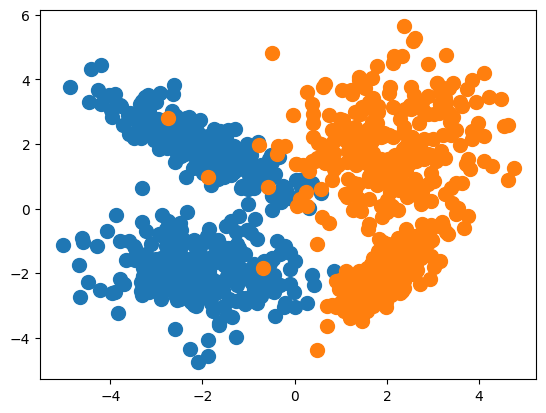

In [3]:
plt.scatter(X[:, 0][y==0], X[:, 1][y==0], s=100)
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], s=100)
plt.show()

In [4]:
class SGD:
    def __init__(self, alpha=0.5, n_iters=1000):
        self.b = None
        self._alpha = alpha
        self._n_iters = n_iters

    def gradient_step(self, b, b_grad):
        return b - self._alpha * b_grad

    def optimize(self, X, y, start_b, n_iters):
        b = start_b.copy()
        for i in range(n_iters):
            b_grad = self.grad_func(X, y, b)
            b = self.gradient_step(b, b_grad)
        return b

    def fit(self, X, y):
        m = X.shape[1]
        start_b = np.ones(m)
        self.b = self.optimize(X, y, start_b, self._n_iters)

In [5]:
class LogReg(SGD):
    def sigmoid(self, X, b):
        return 1. / (1. + np.exp(-X.dot(b)))

    def grad_func(self, X, y, b):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(self.sigmoid(X, b) - y)
        return grad

    def predict_proba(self, X):
        return self.sigmoid(X, self.b)

    def predict(self, X):
        y_pred = self.predict_proba(X) > 0.5
        return y_pred

In [6]:
logreg = LogReg()
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
logreg.fit(X, y)
y_pred = logreg.predict(X)

In [7]:
from sklearn.metrics import accuracy_score, f1_score
ac = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)
print(f'accuracy = {ac:.2f} F1-score = {f1:.2f}')

accuracy = 0.98 F1-score = 0.98


In [8]:
xx, yy = np.meshgrid(
    np.arange(X.min(axis=0)[1]-1, X.max(axis=0)[1]+1, 0.01),
    np.arange(X.min(axis=0)[2]-1, X.max(axis=0)[2]+1, 0.01))
XX = np.array(list(zip(xx.ravel(), yy.ravel()))).reshape((-1, 2))
XX = np.array([(1, *xx) for xx in XX])
Z = logreg.predict_proba(XX)
Z = Z.reshape(xx.shape)

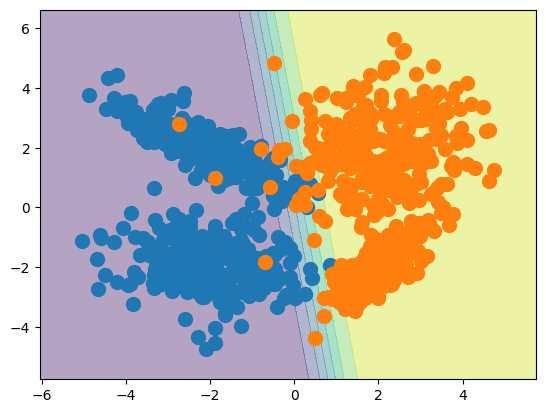

In [9]:
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 1][y==0], X[:, 2][y==0], s=100)
plt.scatter(X[:, 1][y==1], X[:, 2][y==1], s=100)

**1. Выведите результаты работы библиотечной модели - в численном и в графическом виде.**

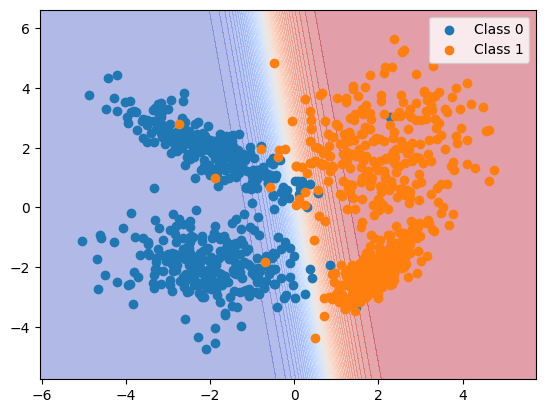

In [10]:
from sklearn.linear_model import LogisticRegression

# Генерация данных
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_classes=2,
    class_sep=2,
    random_state=1
)

model = LogisticRegression()
model.fit(X, y)

# Визуализация
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Получение вероятностей
Z = model.predict_proba(grid_points)[:, 1].reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4, levels=50, cmap='coolwarm')
plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], label="Class 0")
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], label="Class 1")
plt.legend()
plt.show()


**2. Проверьте работу модели с другими значениями скорости обучения. Найдите значение, при котором градиентный спуск расходится.**

In [11]:
# Проверка расхождения при изменении параметра скорости обучения
for c in [1e-10, 1e-4, 1e-2, 0.1, 1, 10, 100]:
    model = LogisticRegression(C=c, solver='lbfgs', max_iter=100)
    try:
        model.fit(X, y)
        score = model.score(X, y)
        print(f"C = {c}: модель сошлась, accuracy = {score:.2f}")
    except Exception as e:
        print(f"C = {c}: модель не сошлась. Ошибка: {e}")

C = 1e-10: модель сошлась, accuracy = 0.50
C = 0.0001: модель сошлась, accuracy = 0.97
C = 0.01: модель сошлась, accuracy = 0.98
C = 0.1: модель сошлась, accuracy = 0.97
C = 1: модель сошлась, accuracy = 0.98
C = 10: модель сошлась, accuracy = 0.98
C = 100: модель сошлась, accuracy = 0.98


Если ошибка растет, это означает, что градиентный спуск расходится

**3. Модифицируйте код модели таким образом, чтобы фиктивный столбец единиц добавлялся к матрице признаков внутри класса.**

In [12]:
# Модификация класса для добавления фиктивного столбца единиц
class LogRegImproved(SGD):
    def __init__(self, alpha=0.5, n_iters=1000):
        super().__init__(alpha=alpha, n_iters=n_iters)

    def add_bias(self, X):
        return np.hstack([np.ones((X.shape[0], 1)), X])

    def sigmoid(self, X, b):
        return 1. / (1. + np.exp(-X.dot(b)))

    def grad_func(self, X, y, b):
        n = X.shape[0]
        grad = 1. / n * X.T.dot(self.sigmoid(X, b) - y)
        return grad

    def fit(self, X, y):
        X = self.add_bias(X)  # Добавляем столбец единиц
        super().fit(X, y)

    def predict_proba(self, X):
        X = self.add_bias(X)  # Добавляем столбец единиц
        return self.sigmoid(X, self.b)

    def predict(self, X):
        return self.predict_proba(X) > 0.5

# Пример использования
logreg_improved = LogRegImproved(alpha=0.5)
logreg_improved.fit(X, y)
y_pred = logreg_improved.predict(X)


**4. Поэкспериментируйте с разными значениями параметра class_sep при генерации датасета. Визуализируйте полученные распределения. Сделайте вывод о том, как этот параметр влияет на точность получаемых моделей.**

Class_sep = 0.5: accuracy = 0.71


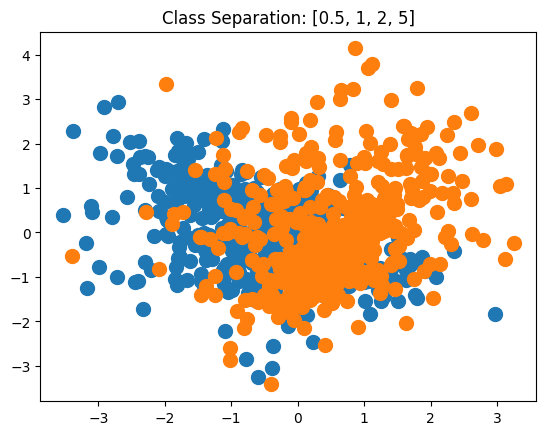

Class_sep = 1: accuracy = 0.85


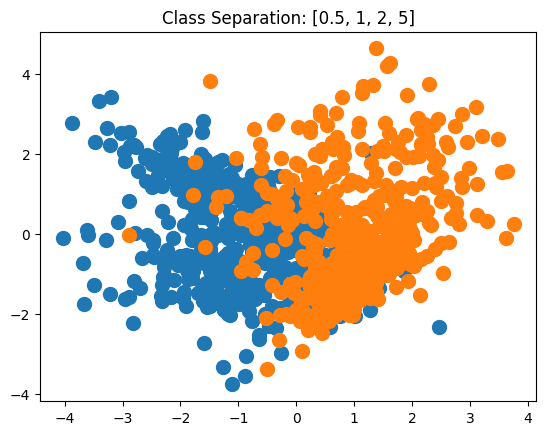

Class_sep = 2: accuracy = 0.98


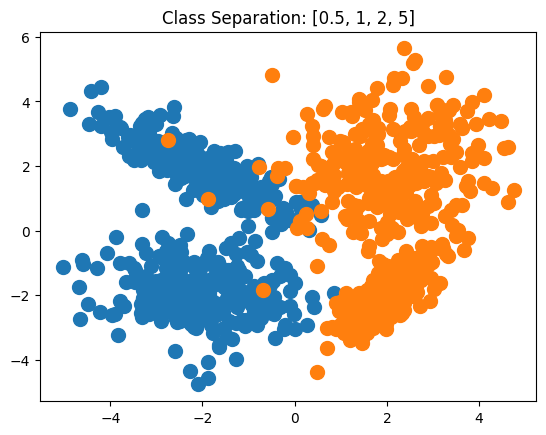

Class_sep = 5: accuracy = 1.00


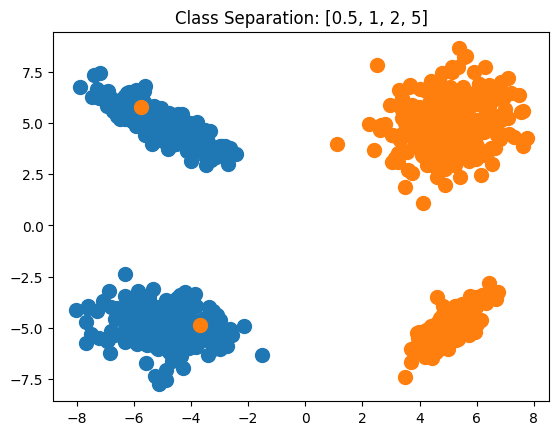

In [13]:
class_seps = [0.5, 1, 2, 5]
for sep in class_seps:
    X, y = make_classification(
        n_samples=1000,
        n_features=2,
        n_informative=2,
        n_redundant=0,
        n_classes=2,
        class_sep=sep,
        random_state=1
    )
    model = LogisticRegression()
    model.fit(X, y)
    score = model.score(X, y)
    print(f"Class_sep = {sep}: accuracy = {score:.2f}")
    plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], s=100)
    plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], s=100)
    plt.title(f"Class Separation: {class_seps}")
    plt.show()

При большем class_sep модель работает точнее.

**5. Сгенерируйте датасет с большим числом признаков и примените к нему созданную модель.**

Accuracy = 0.94


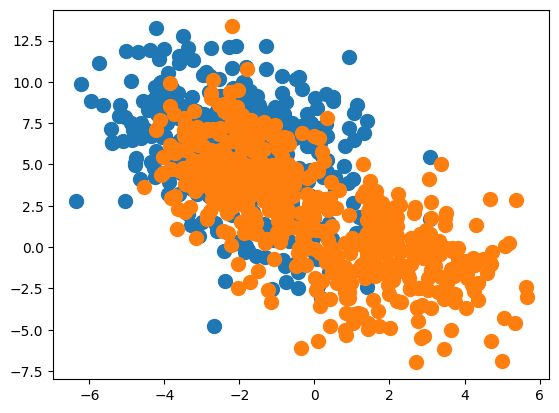

In [14]:
X, y = make_classification(
    n_samples=1000,
    n_features=10,  # Увеличиваем число признаков
    n_informative=8,
    n_redundant=2,
    n_classes=2,
    class_sep=2,
    random_state=1
)

# Создание и обучение модели
model = LogisticRegression()
model.fit(X, y)
print(f"Accuracy = {model.score(X, y):.2f}")
plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], s=100)
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], s=100)
plt.show()

Мы увеличиваем число признаков и убеждаемся, что алгоритм универсален.

**6. Сгенерируйте датасет с большим количеством классов и реализуйте в классе алгоритм "один против всех". Решите задачу множественной классификации средствами sklearn.**

Accuracy = 0.73


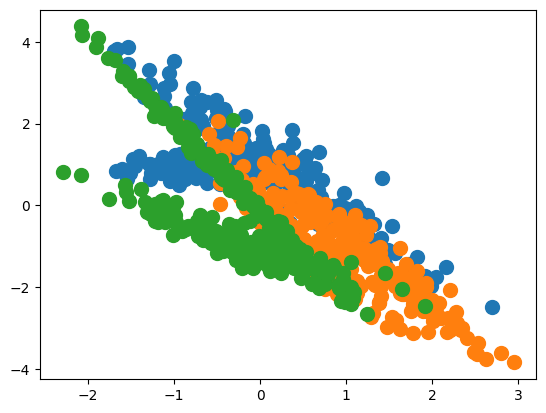

In [15]:
from sklearn.multiclass import OneVsRestClassifier
X, y = make_classification(
    n_samples=1000,
    n_features=5,
    n_informative=3,
    n_redundant=1,
    n_classes=3,  # Увеличиваем число классов
    random_state=1
)

# Создание и обучение модели
model = LogisticRegression(solver='lbfgs', max_iter=500)
OneVsRestClassifier(model.fit(X, y))
print(f"Accuracy = {model.score(X, y):.2f}")
plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], s=100)
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], s=100)
plt.scatter(X[:, 0][y == 2], X[:, 1][y == 2], s=100)
plt.show()

**7. Выведите значения вероятностей для каждого объекта принадлежать тому или иному классу для библиотечной модели LogisticRegression**

In [16]:
y_proba = model.predict_proba(X)
print("Пример вероятностей для первых 5 объектов:")
print(y_proba[:5])

Пример вероятностей для первых 5 объектов:
[[0.04595989 0.16876299 0.78527712]
 [0.52814227 0.03373349 0.43812424]
 [0.94198952 0.0477715  0.01023898]
 [0.8853382  0.04629311 0.06836868]
 [0.28020958 0.65612935 0.06366107]]
